### Part F

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import numpy as np
import pypsa
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
import gurobipy as gp
from gurobipy import GRB
import cartopy.crs as ccrs
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [52]:
"load electricity demand data";
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

"Load the heat demand data";
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime

In [53]:
"Onshore Wind";
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
"Offshore Wind";
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
"Solar Data";
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

In [54]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [55]:
"Time Period in which our model is running";

hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

In [56]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.tz_convert(None))

n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "nuclear")
n.add("Carrier","solar")
n.add("Carrier","heat")


 # CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6
electrolyzer_capex = 350e3
h2_tank_capex = 8.4e3
fuel_cell_capex = 339e3

In [57]:
nodes = pd.Series( ['GBR', 'DNK']).values
neighbors =pd.Series(['DNK']).values
c = list(set(nodes) - set(neighbors))[0]

# longitude
xs = {'GBR':-2.1698,
    'NLD':6.04248,
     "DNK":9.732249,
     }

# latitude
ys = {'GBR':53.243852,
      'NLD':52.709675,
     'DNK':55.990430,
     }

# this is in MW
Nuclear_Cap = {'GBR':65000,
      'NLD':500,
     'DNK':0,
     }

n.madd("Bus",
       names=nodes,
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       carrier="electricity")

Index(['GBR', 'DNK'], dtype='object')

In [58]:
"Electrical Loads";
n.madd(
    "Load",
    names=["electric load " + n for n in nodes],  # Unique names for electrical loads
    bus=nodes,  # Assign to the corresponding electricity buses
    p_set=df_elec[nodes].values  # Electricity demand values
)

Index(['electric load GBR', 'electric load DNK'], dtype='object')

In [59]:
CF_wind_on = pd.DataFrame()
CF_wind_off = pd.DataFrame()
CF_solar = pd.DataFrame()
for i in range(len(nodes)):
    CF_wind_on[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_wind_off[nodes[i]] = df_offshore[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

In [60]:
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
        nodes + " onshorewind",
        bus=nodes,
        p_nom_extendable=True,
        carrier="onshorewind",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_onshorewind,
        marginal_cost = 0,
        p_max_pu = CF_wind_on[nodes].values)

capital_cost_offshorewind = annuity(25,0.07)*offshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
            nodes + " offshorewind",
            bus=nodes,
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off[nodes].values)

"CCGT (Combine Cycle Gas Turbine) generator";
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
n.madd("Generator",
            nodes + " CCGT",
            bus=nodes,
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)
"Solar";
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
n.madd("Generator",
                  nodes + " solar",
                  bus= nodes,
                  p_nom_extendable=True,
                  carrier="solar",
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_solar,
                  marginal_cost = 0,
                  p_max_pu = CF_solar.values)

"Nuclear";
capital_cost_nuclear = annuity(40,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el

n.madd("Generator",
                  nodes + " nuclear",
                  bus = nodes,
                  p_nom_extendable=True,
                  carrier="nuclear",
                  p_nom_max = [Nuclear_Cap[n] for n in nodes],
                  capital_cost = capital_cost_nuclear,
                  marginal_cost = marginal_cost_nuclear)

Index(['GBR nuclear', 'DNK nuclear'], dtype='object')

Total viking link capex: 855 million euros. Total capacity: 1400 MW

In [61]:

# Add Viking link
viking_link_length = 765 # in km
capex_viking_link = 1.1186928104575162 # in €/MW 
n.add("Link",
      "Viking Link",
      bus0="GBR",
      bus1="DNK",
      p_nom = 3000,#1400, # in MW
      p_min_pu=-1, # negative flow possible (import from DNK to GBR)
      p_max_pu=1, # positive flow possible (export from GBR to DNK)
      r_per_length = 9.3e-3, # in ohm/km
      length = viking_link_length, # in km
      capital_cost = capex_viking_link,  # in €/MW
      overwrite=True
) 

Index(['Viking Link'], dtype='object')

In [62]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,


In [63]:
n.optimize(n.snapshots,
             solver_name='gurobi',
             Output_flag = 0)

Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 19.26it/s]
INFO:linopy.io: Writing time: 1.02s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-5id5hzob.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-5id5hzob.lp


Reading time = 0.37 seconds


INFO:gurobipy:Reading time = 0.37 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.29e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


('ok', 'optimal')

<Axes: title={'center': 'Flow from GBR to DNK'}, xlabel='snapshot', ylabel='flow'>

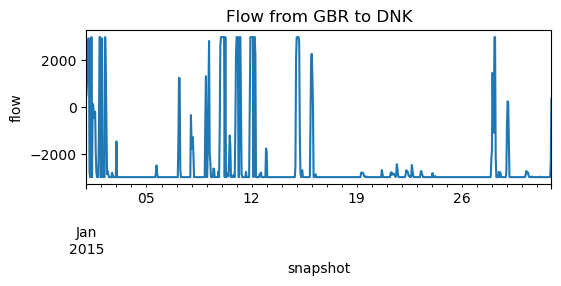

In [64]:
n.links_t.p0.loc["2015-01", "Viking Link"].plot(figsize=(6, 2), ylabel="flow", title="Flow from GBR to DNK")

In [65]:
n.generators.p_nom_opt

Generator
GBR onshorewind     48782.306511
DNK onshorewind      9396.285018
GBR offshorewind        0.000000
DNK offshorewind        0.000000
GBR CCGT            46991.135671
DNK CCGT             7819.043459
GBR solar               0.000000
DNK solar               0.000000
GBR nuclear             0.000000
DNK nuclear             0.000000
Name: p_nom_opt, dtype: float64

In [66]:
n.lines_t.p0.sum()

Series([], dtype: float64)

ValueError: Axis is a geo axis, but `geomap` is set to False

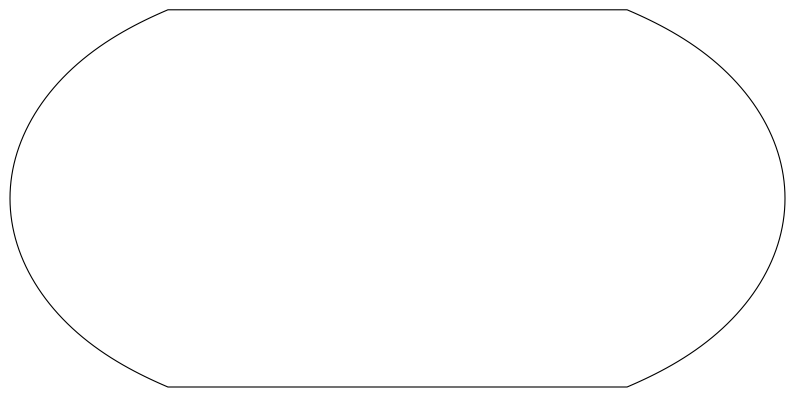

In [67]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(10, 10)
)

load_distribution = (
    n.loads_t.p_set.loc[n.snapshots[0]].groupby(n.loads.bus).sum()
)
n.plot(bus_sizes=0.5e-5 * load_distribution,margin= 1 ,ax=ax, title="Load distribution");

In [ ]:
load_distribution

bus
DNK     3210.98
GBR    29059.00
Name: 2015-01-01 00:00:00, dtype: float64

In [ ]:
n.generators_t.p["DNK offshorewind"].sum()
n.generators_t.p["DNK onshorewind"].sum()
n.generators_t.p["DNK solar"].sum()
n.generators_t.p["DNK nuclear"].sum()
n.generators_t.p["DNK CCGT"].sum()

np.float64(18996057.954290908)

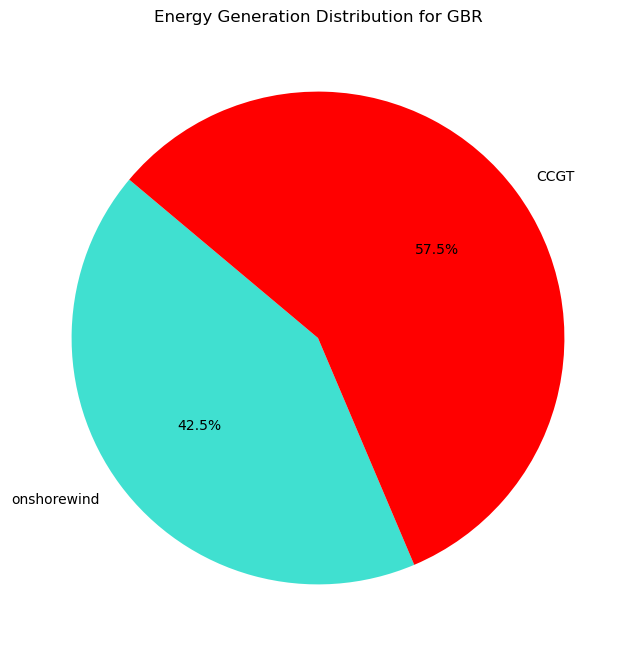

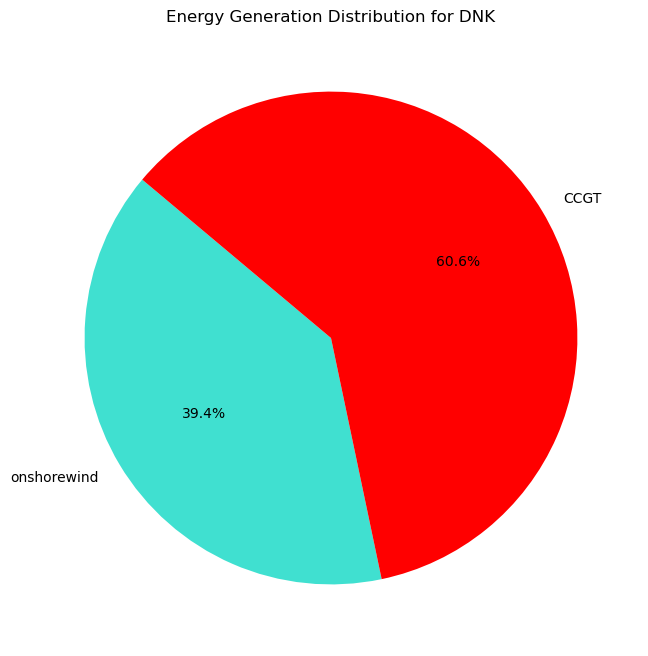

In [ ]:
import matplotlib.pyplot as plt

# List of countries
countries = ['GBR', 'DNK']

# List of energy sources
energy_sources = ['offshorewind', 'onshorewind', 'solar', 'nuclear', 'CCGT']

# Colors for the pie chart
colors = ['lightblue', 'turquoise', 'orange', 'lightgreen', 'red']

# Loop through each country
for country in countries:
    # Calculate the generation sums for each energy source
    sizes = [n.generators_t.p[f"{country} {source}"].sum() for source in energy_sources]
    
    # Filter out sources with approximately zero contribution
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [energy_sources[i] for i in range(len(sizes)) if sizes[i] > 0]
    filtered_colors = [colors[i] for i in range(len(sizes)) if sizes[i] > 0]
    
    # Create the pie chart
    if filtered_sizes:  # Only plot if there are non-zero contributions
        plt.figure(figsize=(8, 8))
        plt.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140, colors=filtered_colors)
        plt.title(f'Energy Generation Distribution for {country}')
        plt.show()

In [ ]:
gen = n.generators.assign(g=n.generators_t.p.sum()).groupby(["bus", "carrier"]).g.sum();
gen

bus  carrier     
DNK  gas             1.899606e+07
     nuclear         0.000000e+00
     offshorewind    0.000000e+00
     onshorewind     1.381788e+07
     solar           0.000000e+00
GBR  gas             1.706459e+08
     nuclear         0.000000e+00
     offshorewind    0.000000e+00
     onshorewind     1.115493e+08
     solar           0.000000e+00
Name: g, dtype: float64

In [ ]:
n.generators.p_nom_opt.loc[n.generators.bus == "DNK"].sum()

np.float64(11025.584157575759)

In [ ]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
gas,0.19,,,inf,0.0
onshorewind,0.00,,,inf,0.0
offshorewind,0.00,,,inf,0.0
nuclear,0.00,,,inf,0.0
solar,0.00,,,inf,0.0
heat,0.00,,,inf,0.0


In [ ]:
# Define the CO2 constraint values for sensitivity analysis
viking_link_capacity = [0, 250, 500, 750, 1000, 1400, 1800, 3000,5000,10000,15000]  # in MW

results = []

# Loop through each CO2 limit
for capacity in viking_link_capacity:
    # Change the capacity of the Viking Link
    n.links.at["Viking Link", "p_nom"] = capacity
    
    # Solve the network
    n.optimize(n.snapshots,
                 solver_name='gurobi',
                 Output_flag = 0)

    system_cost = n.objective

    dnk_capacity = n.generators.p_nom_opt.loc[n.generators.bus == "DNK"].sum()
    gbr_capacity = n.generators.p_nom_opt.loc[n.generators.bus == "GBR"].sum()
    # Extract the optimized generator capacities
    results.append({
        "System cost": system_cost,
        "Viking Link capacity": capacity,
        "DNK energy mix": {
            "offshorewind": n.generators_t.p["DNK offshorewind"].sum(),
            "onshorewind": n.generators_t.p["DNK onshorewind"].sum(),
            "solar": n.generators_t.p["DNK solar"].sum(),
            "nuclear": n.generators_t.p["DNK nuclear"].sum(),
            "CCGT": n.generators_t.p["DNK CCGT"].sum()
        },
        "GBR energy mix": {
            "offshorewind": n.generators_t.p["GBR offshorewind"].sum(),
            "onshorewind": n.generators_t.p["GBR onshorewind"].sum(),
            "solar": n.generators_t.p["GBR solar"].sum(),
            "nuclear": n.generators_t.p["GBR nuclear"].sum(),
            "CCGT": n.generators_t.p["GBR CCGT"].sum()
        },
        "DNK installed capacity": dnk_capacity,
        "GBR installed capacity": gbr_capacity,
    })

# Save the results to a CSV file for further analysis
# results.to_csv("sensitivity_analysis_results.csv", index=False)

# Display the results
print(results)

Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 19.82it/s]
INFO:linopy.io: Writing time: 1.07s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-qmm1u16l.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-qmm1u16l.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.31e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 17.96it/s]
INFO:linopy.io: Writing time: 1.15s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-gwhhogm5.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-gwhhogm5.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.72it/s]
INFO:linopy.io: Writing time: 1.0s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-o929164s.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-o929164s.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.20it/s]
INFO:linopy.io: Writing time: 1.03s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-7l6kibxt.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-7l6kibxt.lp


Reading time = 0.28 seconds


INFO:gurobipy:Reading time = 0.28 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 19.30it/s]
INFO:linopy.io: Writing time: 1.02s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-xpix92p7.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-xpix92p7.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.43it/s]
INFO:linopy.io: Writing time: 1.0s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-sccdzmdl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-sccdzmdl.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.54it/s]
INFO:linopy.io: Writing time: 0.99s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-d90v7mn0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-d90v7mn0.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.30e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.23it/s]
INFO:linopy.io: Writing time: 1.04s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-pj5x1pi0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-pj5x1pi0.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.29e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 19.31it/s]
INFO:linopy.io: Writing time: 1.05s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-e5n4fr4o.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-e5n4fr4o.lp


Reading time = 0.30 seconds


INFO:gurobipy:Reading time = 0.30 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.29e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.11it/s]
INFO:linopy.io: Writing time: 1.04s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-0h0_b5n1.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-0h0_b5n1.lp


Reading time = 0.29 seconds


INFO:gurobipy:Reading time = 0.29 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.28e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
Index(['GBR', 'DNK'], dtype='object', name='Bus')
Index(['Viking Link'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Output_flag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 20.19it/s]
INFO:linopy.io: Writing time: 1.04s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-s3_keg0v.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-s3_keg0v.lp


Reading time = 0.32 seconds


INFO:gurobipy:Reading time = 0.32 seconds


obj: 210252 rows, 96370 columns, 376833 nonzeros


INFO:gurobipy:obj: 210252 rows, 96370 columns, 376833 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 210252 duals
Objective: 2.28e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.


[{'System cost': 23078786157.532, 'Viking Link capacity': 0, 'DNK energy mix': {'offshorewind': 0.0, 'onshorewind': 13817881.175709091, 'solar': 0.0, 'nuclear': 0.0, 'CCGT': 18996057.954290908}, 'GBR energy mix': {'offshorewind': 0.0, 'onshorewind': 111549255.41078839, 'solar': 0.0, 'nuclear': 0.0, 'CCGT': 170645933.5892116}, 'DNK installed capacity': 11025.584157575759, 'GBR installed capacity': 99895.46473029046}, {'System cost': 23024464399.512943, 'Viking Link capacity': 250, 'DNK energy mix': {'offshorewind': 0.0, 'onshorewind': 14516161.494537652, 'solar': 0.0, 'nuclear': 0.0, 'CCGT': 20233420.11951749}, 'GBR energy mix': {'offshorewind': 0.0, 'onshorewind': 111877789.26733255, 'solar': 0.0, 'nuclear': 0.0, 'CCGT': 168381757.24861228}, 'DNK installed capacity': 11056.161158798284, 'GBR installed capacity': 99769.12121212122}, {'System cost': 23008910556.348793, 'Viking Link capacity': 500, 'DNK energy mix': {'offshorewind': 0.0, 'onshorewind': 15160991.633023256, 'solar': 0.0, 'n

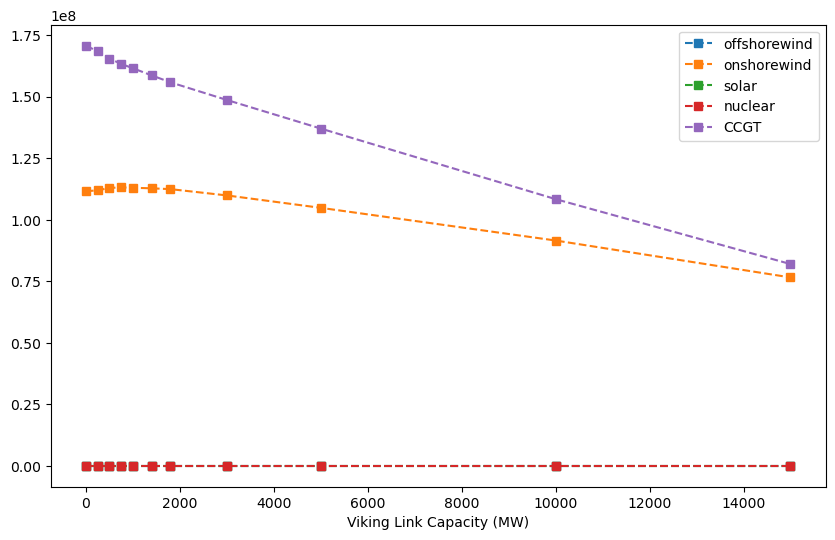

In [ ]:
# Plot variation of electricity mix with Viking Link capacity
fig, ax = plt.subplots(figsize=(10, 6))
for i, source in enumerate(energy_sources):
    ax.plot(viking_link_capacity, [result["GBR energy mix"][source] for result in results], '--s', label=source)
ax.set_xlabel("Viking Link Capacity (MW)")

ax.legend()